In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Scaling

In [2]:
# Define your scaling function
def custom_scaling(input_values):
    input_values_scaled = np.zeros_like(input_values, dtype=float)  # Initialize scaled data array
    input_values_scaled[:, 0] = (input_values[:, 0] - L_min) / (L_max - L_min)  # Scale L
    input_values_scaled[:, 1] = (input_values[:, 1] - C_min) / (C_max - C_min)  # Scale C
    input_values_scaled[:, 2] = (input_values[:, 2] - fsw_min) / (fsw_max - fsw_min)  # Scale fsw
    return input_values_scaled

# Search N and H

In [3]:


# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
df = pd.read_csv(r"D:\Krishna\ai-power-converter-1\dataset\simulation_results_new.csv")

# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw']].values

# Extract output (ripples)
y = df[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3

X_scaled = custom_scaling(X)

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)# Initialize a dictionary to store the training history for each configuration


histories = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses = {}
maes = {}
rmses = {}
r2_scores = {}
mapes = {}

# Define a list of different values for H and Nh to try
H_values = [1, 2, 3, 4, 5, 6, 7, 8]  # Number of hidden layers
Nh_values = [16, 32, 64, 128, 256, 512]  # Number of neurons per hidden layer

Epoch 1/100, Loss: 0.6796928644180298, Val Loss: 0.3131573796272278
Epoch 2/100, Loss: 0.2724306583404541, Val Loss: 0.2303534746170044
Epoch 3/100, Loss: 0.2679535746574402, Val Loss: 0.23179017007350922
Epoch 4/100, Loss: 0.2681836783885956, Val Loss: 0.22741220891475677
Epoch 5/100, Loss: 0.2678540349006653, Val Loss: 0.22654083371162415
Epoch 6/100, Loss: 0.26691490411758423, Val Loss: 0.22502148151397705
Epoch 7/100, Loss: 0.2669089734554291, Val Loss: 0.2312905341386795
Epoch 8/100, Loss: 0.26625683903694153, Val Loss: 0.227632537484169
Epoch 9/100, Loss: 0.266415536403656, Val Loss: 0.22450512647628784
Epoch 10/100, Loss: 0.26592928171157837, Val Loss: 0.22311954200267792
Epoch 11/100, Loss: 0.26393747329711914, Val Loss: 0.23693488538265228
Epoch 12/100, Loss: 0.25718405842781067, Val Loss: 0.21542099118232727
Epoch 13/100, Loss: 0.24903258681297302, Val Loss: 0.20334139466285706
Epoch 14/100, Loss: 0.24538537859916687, Val Loss: 0.20316769182682037
Epoch 15/100, Loss: 0.243109

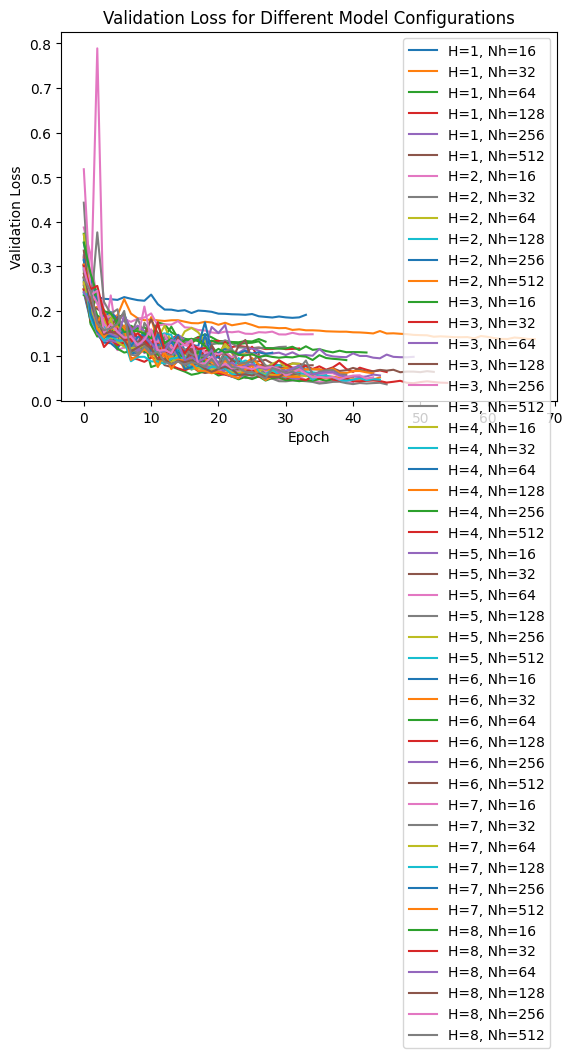

Model with H=1 and Nh=16:
MSE: 0.19482405483722687
MAE: 0.19482412566142351
RMSE: 0.7028564033375245
R-squared: 0.7453174961520496
MAPE: 16.268475962312262%
Model with H=1 and Nh=32:
MSE: 0.1405729353427887
MAE: 0.1405729001292239
RMSE: 0.43013883773324435
R-squared: 0.8863349445846099
MAPE: 10.608490793572004%
Model with H=1 and Nh=64:
MSE: 0.13279645144939423
MAE: 0.13279640226079356
RMSE: 0.4074776562795288
R-squared: 0.8845711558458692
MAPE: 10.31430897865557%
Model with H=1 and Nh=128:
MSE: 0.11693369597196579
MAE: 0.11693372275464853
RMSE: 0.37513016763265955
R-squared: 0.9457910969443771
MAPE: 8.64165537356915%
Model with H=1 and Nh=256:
MSE: 0.12019405514001846
MAE: 0.12019404814302816
RMSE: 0.36862250676096714
R-squared: 0.9374158370255207
MAPE: 9.502624425481525%
Model with H=1 and Nh=512:
MSE: 0.08049308508634567
MAE: 0.08049306380301827
RMSE: 0.26528394144128115
R-squared: 0.9631716533463305
MAPE: 6.020872429112164%
Model with H=2 and Nh=16:
MSE: 0.14974857866764069
MAE: 0.

In [4]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(3,)))  
        model.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model.add(tf.keras.layers.Dense(6, activation='softplus'))  

        # Compile the model
        model.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories[(H, Nh)] = history

        # Evaluate the model on the testing set
        predictions = model.predict(X_test)

        # Evaluate the model on the testing set and calculate MSE
        mse = model.evaluate(X_test, y_test)
        mses[(H, Nh)] = mse

        # Calculate Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, predictions)
        maes[(H, Nh)] = mae

        # Calculate Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        rmses[(H, Nh)] = rmse

        # Calculate R-squared (R2) Score
        r2 = r2_score(y_test, predictions)
        r2_scores[(H, Nh)] = r2

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
        mapes[(H, Nh)] = mape

# Plot the validation loss for each configuration
for (H, Nh), history in histories.items():
    plt.plot(history.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# Print the evaluation metrics for each configuration
for (H, Nh), mse in mses.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse}')
    print(f'MAE: {maes[(H, Nh)]}')
    print(f'RMSE: {rmses[(H, Nh)]}')
    print(f'R-squared: {r2_scores[(H, Nh)]}')
    print(f'MAPE: {mapes[(H, Nh)]}%')


## Ranking

In [6]:
# Rank combinations based on their MSE values
ranked_combinations = sorted(mses.items(), key=lambda x: x[1])

# Print ranked combinations
for idx, ((H, Nh), mse) in enumerate(ranked_combinations, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse}")


Rank 1: Combination H=3, Nh=512 - MSE: 0.038650162518024445
Rank 2: Combination H=4, Nh=512 - MSE: 0.0411871001124382
Rank 3: Combination H=3, Nh=256 - MSE: 0.042984310537576675
Rank 4: Combination H=4, Nh=256 - MSE: 0.0449877567589283
Rank 5: Combination H=7, Nh=128 - MSE: 0.045550573617219925
Rank 6: Combination H=7, Nh=512 - MSE: 0.04737043008208275
Rank 7: Combination H=8, Nh=256 - MSE: 0.047516971826553345
Rank 8: Combination H=4, Nh=128 - MSE: 0.048014070838689804
Rank 9: Combination H=6, Nh=256 - MSE: 0.04886127635836601
Rank 10: Combination H=2, Nh=512 - MSE: 0.04918761923909187
Rank 11: Combination H=8, Nh=512 - MSE: 0.05136493965983391
Rank 12: Combination H=6, Nh=128 - MSE: 0.05258362367749214
Rank 13: Combination H=8, Nh=64 - MSE: 0.05335165560245514
Rank 14: Combination H=8, Nh=128 - MSE: 0.05409397557377815
Rank 15: Combination H=7, Nh=64 - MSE: 0.0557793565094471
Rank 16: Combination H=5, Nh=64 - MSE: 0.055810343474149704
Rank 17: Combination H=7, Nh=32 - MSE: 0.05783172

## Try spesific N and H

In [7]:
# Specify the combination you want to call
H = 5
Nh = 128

# Retrieve the model for the specified combination
selected_model = histories[(H, Nh)].model

# Use the trained model to make predictions on the testing set
predictions = selected_model.predict(X_test)

# Print the first few predictions
print("Predictions:")
print(predictions[:5])

# Print the corresponding true values
print("True Values:")
print(y_test[:5])

127/127 [==============================] - 0s 631us/step
Predictions:
[[2.87525766e-02 7.79247284e-01 3.09456277e+00 3.10579586e+00
  1.89681705e-02 2.11162758e+00]
 [4.46155310e+00 4.47152567e+00 2.23543242e-01 2.55223083e+00
  1.68272983e-02 2.76224017e-01]
 [1.43909767e-01 8.85467815e+00 3.53712511e+00 3.51360083e+00
  6.86740503e-03 1.18036652e+00]
 [7.30786398e-02 1.11405528e+00 3.52360392e+00 3.53932023e+00
  2.15347204e-02 9.64191377e-01]
 [2.64830850e-02 1.22409534e+00 3.37325144e+00 3.38549471e+00
  1.34525625e-02 2.09442711e+00]]
True Values:
[[3.73126122e-02 7.47245981e-01 3.03643319e+00 3.03643319e+00
  1.72160434e-02 2.15202491e+00]
 [9.49393284e-01 4.47959053e+00 1.85248205e+00 1.85248205e+00
  7.27748221e-02 1.05888718e+00]
 [1.82801723e-01 9.05225544e+00 3.44051329e+00 3.44051329e+00
  6.14689682e-03 1.17069267e+00]
 [7.21944866e-02 1.01012118e+00 3.53549404e+00 3.53549404e+00
  2.30594268e-02 9.72148356e-01]
 [2.94638994e-02 1.12389005e+00 3.32770238e+00 3.32770238e+00

# Machine Learning

Epoch 1/50
175/175 [==============================] - 1s 2ms/step - loss: 1.2312 - val_loss: 1.8220
Epoch 2/50
175/175 [==============================] - 0s 1ms/step - loss: 0.7014 - val_loss: 0.9146
Epoch 3/50
175/175 [==============================] - 0s 1ms/step - loss: 0.5161 - val_loss: 0.4631
Epoch 4/50
175/175 [==============================] - 0s 1ms/step - loss: 0.4439 - val_loss: 0.3551
Epoch 5/50
175/175 [==============================] - 0s 1ms/step - loss: 0.3981 - val_loss: 0.2742
Epoch 6/50
175/175 [==============================] - 0s 1ms/step - loss: 0.3696 - val_loss: 0.2336
Epoch 7/50
175/175 [==============================] - 0s 1ms/step - loss: 0.3615 - val_loss: 0.2677
Epoch 8/50
175/175 [==============================] - 0s 1ms/step - loss: 0.3536 - val_loss: 0.2804
Epoch 9/50
175/175 [==============================] - 0s 1ms/step - loss: 0.3828 - val_loss: 0.2224
Epoch 10/50
175/175 [==============================] - 0s 1ms/step - loss: 0.3367 - val_loss: 0.2040

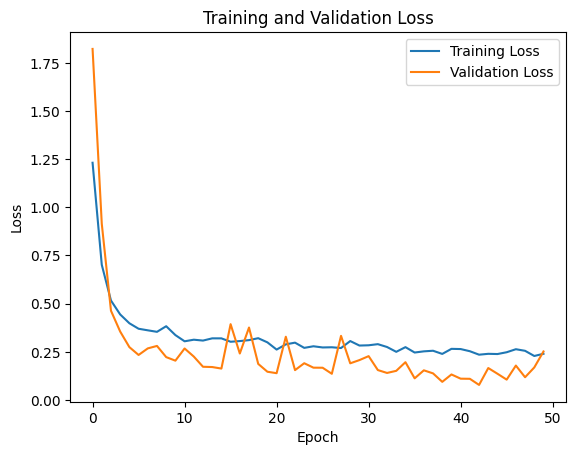

In [3]:
# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\modified_8000_dataset.csv")

# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw']].values

# Extract output (ripples)
y = df[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3

# Apply custom scaling
X_scaled = custom_scaling(X)

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")

# Assuming you have already defined your machine learning model and dataset
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1, patience=2, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)

model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=(3,)),  # Scalarization layer
    tf.keras.layers.Dense(128, activation='relu'),          # Hidden layer 1
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(128, activation='relu'),          # Hidden layer 2
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(128, activation='relu'),          # Hidden layer 2
    tf.keras.layers.BatchNormalization(),         
    tf.keras.layers.Dense(6, activation='softplus')                               # Output layer with 6 neurons
])

# model = tf.keras.Sequential([
#     tf.keras.layers.BatchNormalization(input_shape=(3,)),  # Scalarization layer
#     tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 1
#     tf.keras.layers.BatchNormalization(),                  # Batch normalization
#     tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 2
#     tf.keras.layers.BatchNormalization(),                  # Batch normalization
#     tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 2
#     tf.keras.layers.BatchNormalization(),         
#     tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 2
#     tf.keras.layers.BatchNormalization(),                  # Batch normalization
#     tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 2
#     tf.keras.layers.BatchNormalization(),         
#     tf.keras.layers.Dense(6, activation='softplus')                               # Output layer with 6 neurons
# ])


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model with given hyperparameters
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing Set

In [7]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Evaluate the model on the testing set
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse)

# Use the trained model to make predictions on the testing set
predictions = model.predict(X_test)

# Print the first few predictions
print("Predictions:")
print(predictions[:5])

# Print the corresponding true values
print("True Values:")
print(y_test[:5])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate R-squared (R2) Score
r2 = r2_score(y_test, predictions)
print(f'R-squared (R2) Score: {r2}')

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

38/38 [==============================] - 0s 606us/step - loss: 0.1632
Mean Squared Error on Testing Set: 0.16320562362670898
38/38 [==============================] - 0s 499us/step
Predictions:
[[0.20654827 6.483947   2.6345077  2.6322153  0.01708872 1.3133281 ]
 [0.12445674 4.282261   3.5189834  3.520649   0.00829306 1.0214925 ]
 [0.14707306 6.546033   3.3875675  3.4100778  0.00850959 1.2893308 ]
 [0.06795892 4.3753366  2.3814638  2.3742485  0.01889426 2.3163981 ]
 [0.06067272 0.20301414 2.079679   2.104424   0.14704187 2.053334  ]]
True Values:
[[0.26001435 4.23264405 2.74299141 2.74299141 0.01217656 1.29224261]
 [0.19503469 3.32206237 3.59940991 3.59940991 0.00902757 0.95760415]
 [0.23933468 4.23420079 3.51435724 3.51435724 0.00733677 1.291914  ]
 [0.08042573 4.24613856 2.40471154 2.40471154 0.02217949 2.34150863]
 [0.07897327 0.58997409 2.02413572 2.02413572 0.16765618 2.15456352]]
Mean Absolute Error (MAE): 0.13914263041641098
Root Mean Squared Error (RMSE): 0.4039871578126952
R-sq

## Save Model

In [ ]:
# Evaluate the model on the testing set
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse)

# Optionally, save the model
model.save("ripples_prediction_model.h5")
